Import packages

In [86]:
import numpy as np
import pandas as pd
import datetime
import glob
import warnings
from IPython import display

Scheme of ETL process

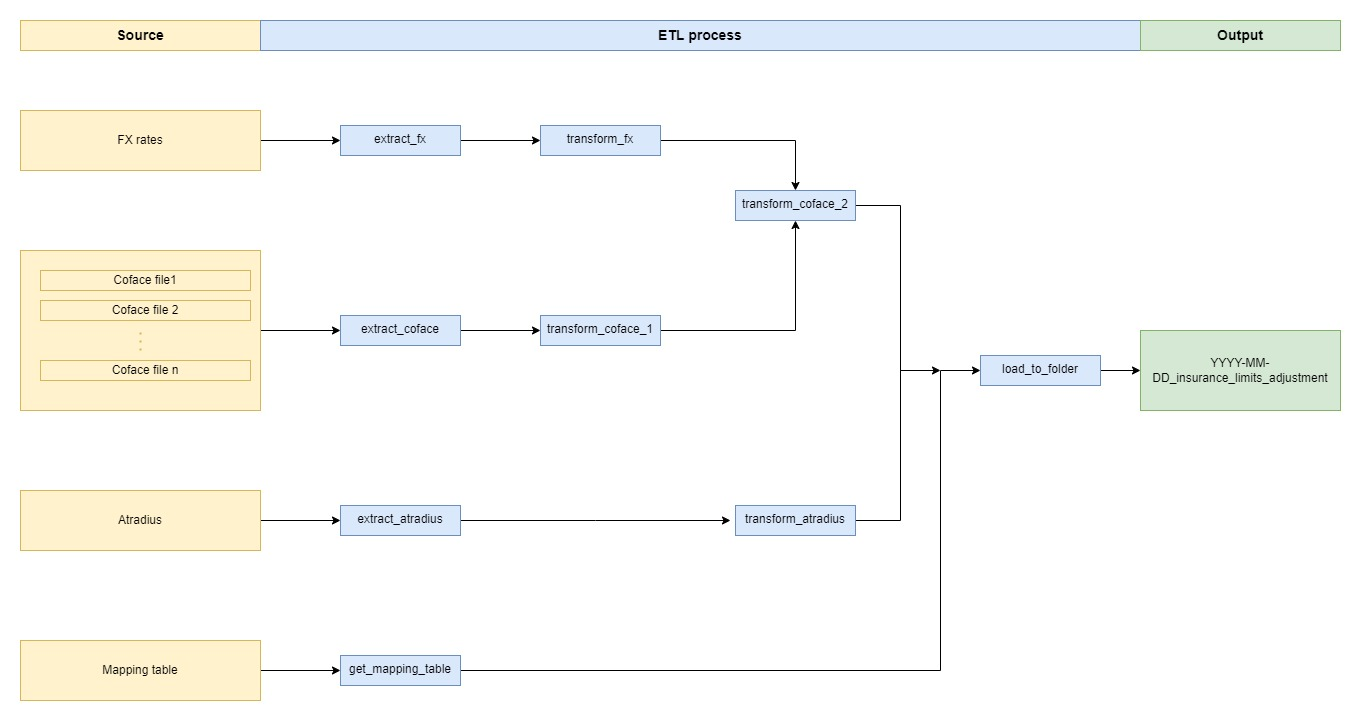

In [87]:
display.Image("etl_scheme_insurance_adjustments.jpg", height=800, width=1200)

1. Parameters

2. Data blocks

2.1. Exchange rates

In [89]:
def extract_fx(folder_path: str, date_str: str) -> pd.DataFrame:
    """
    Extracts foreign exchange data from a CSV file located in the specified folder
    corresponding to the given date.

    Parameters:
    - folder_path (str): The path to the folder containing the CSV files.
    - date_str (str): The date in the format 'YYYY-MM-DD' for which the FX data is required.

    Returns:
    - pd.DataFrame: A DataFrame containing the foreign exchange data.

    Raises:
    - IndexError: If no file corresponding to the provided date is found in the folder.
    
    Example:
    >>> df = extract_fx('/path/to/folder', '2023-01-01')
    """
    try:
        date_yyyymm = datetime.datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y%m')
        file_path_fx =  glob.glob(folder_path + "/*" + date_yyyymm + "*")[0]
        df_fx = pd.read_csv(file_path_fx, sep=';', thousands =".", decimal=',')
        return df_fx
    
    except IndexError:
        print(f"File containing name {date_yyyymm} does not exist")

In [90]:
def transform_fx(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the foreign exchange DataFrame by cleaning column names and selecting
    relevant columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing foreign exchange data.

    Returns:
    - pd.DataFrame: A transformed DataFrame with cleaned column names and selected columns.

    Raises:
    - None.

    Example:
    >>> cleaned_df = transform_fx(fx_data)
    """
    if df is not None:
        df.columns = df.columns.str.strip().str.lower().str.replace('.', '').str.replace(' ', '_')
        df = df[['currency', 'rate']]
        return df
    else:
        print("FX dataframe dooes not exist")

In [91]:
df_fx = extract_fx(folder_path_fx, date_str)
df_fx = transform_fx(df=df_fx)

2.2. Coface dataset

In [93]:
def extract_coface(folder_path: str, date_str: str) -> pd.DataFrame:
    """
    Extracts Coface insurance data from Excel files located in the specified folder
    corresponding to the given date.

    Parameters:
    - folder_path (str): The path to the folder containing the insurance data files.
    - date_str (str): The date in the format 'YYYY-MM-DD' for which the data is required.

    Returns:
    - pd.DataFrame: A DataFrame containing the Coface insurance data.

    Raises:
    - None.

    Example:
    >>> coface_data = extract_coface('/path/to/folder', '2023-01-01')
    """
    folder_insurance_year_month = datetime.datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m')
    files_list = glob.glob(folder_path + '/' + folder_insurance_year_month + '/RISK*') 

    container_xlsx = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for file in files_list:
            try:
                df_temp = pd.read_excel(file, engine='openpyxl')
                df_temp.columns = df_temp.columns.str.strip().str.lower().str.replace('.', '').str.replace(' ', '_')
                df_temp = df_temp.rename(columns={'contract_number': 'contract'}) # enable when 'contract'columns not found
                df_temp = df_temp[['contract', 'easy_no', 'international_business_name', 'country_name', 'decision_status', 'effect_date', 'amount_agreed', 'currency_amount_agreed']]
                container_xlsx.append(df_temp)
            except Exception as error:
                print(f"Error in file: {file}. \nError message: {error}")
    
    return pd.concat(container_xlsx, ignore_index=True)

In [94]:
def transform_coface_1(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the Coface insurance DataFrame by filtering data based on decision status,
    removing duplicates, and selecting relevant columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing Coface insurance data.

    Returns:
    - pd.DataFrame: A transformed DataFrame with filtered data and selected columns.

    Raises:
    - None.

    Example:
    >>> transformed_df = transform_coface_1(coface_data)
    """
    # decision_status is 'agree', drop NA value and equaling 0
    df.loc[:, 'decision_status'] = df.loc[:, 'decision_status'].str.lower().str.replace(' ', '_')
    df = df.loc[df['decision_status'] == 'agreed', :]
    df = df.loc[df['amount_agreed'].notna() & df['amount_agreed'] != 0, :]
    
    # From duplicates get one with recent effect_date
    df = df.sort_values(by=['contract', 'easy_no', 'effect_date'], ascending=[False, False, False])
    df = df.drop_duplicates(subset=['contract', 'easy_no'], keep='first', ignore_index=True)

    df = df[['contract', 'easy_no', 'international_business_name', 'country_name', 'amount_agreed', 'currency_amount_agreed']]

    return df

In [95]:
def transform_coface_2(df: pd.DataFrame, folder_path_fx: str, date_str: str) -> pd.DataFrame:
    """
    Transforms the Coface insurance DataFrame by merging it with foreign exchange data,
    calculating credit limits, and selecting relevant columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing Coface insurance data.
    - folder_path_fx (str): The path to the folder containing foreign exchange data files.
    - date_str (str): The date in the format 'YYYY-MM-DD' for which the foreign exchange data is required.

    Returns:
    - pd.DataFrame: A transformed DataFrame with merged data and calculated credit limits.

    Raises:
    - None.

    Example:
    >>> transformed_df = transform_coface_2(coface_data, '/path/to/folder', '2023-01-01')
    """
    df_fx = extract_fx(folder_path=folder_path_fx, date_str=date_str)
    df_fx = transform_fx(df=df_fx)
    df = df.merge(df_fx, how='left', left_on='currency_amount_agreed', right_on='currency')

    df['credit_limit'] = np.where(df['currency_amount_agreed']=='EUR', df['amount_agreed'], np.round(df['amount_agreed']/df['rate']))
    df = df[['contract', 'easy_no', 'international_business_name', 'country_name', 'credit_limit']]

    col_rename_coface = {'contract': 'contract_id', 'easy_no': 'debtor_id', 'international_business_name': 'debtor_name'}
    df = df.rename(columns=col_rename_coface)

    return df

In [96]:
df_coface = extract_coface(folder_path=folder_path_insurance, date_str=date_str)
df_coface = transform_coface_1(df=df_coface)
df_coface = transform_coface_2(df=df_coface, folder_path_fx=folder_path_fx, date_str=date_str)

C:\Users\PLKONA\AppData\Local\Temp\ipykernel_19576\3806650393.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(container_xlsx, ignore_index=True)


2.3. Atradius dataset

In [99]:
def extract_atradius(folder_path: str, date_str: str) -> pd.DataFrame:
    """
    Extracts Atradius insurance data from an Excel file located in the specified folder
    corresponding to the given date.

    Parameters:
    - folder_path (str): The path to the folder containing the insurance data file.
    - date_str (str): The date in the format 'YYYY-MM-DD' for which the data is required.

    Returns:
    - pd.DataFrame: A DataFrame containing the Atradius insurance data.

    Raises:
    - IndexError: If no file corresponding to the provided date is found in the folder.
    - Exception: If an error occurs during the extraction process.

    Example:
    >>> atradius_data = extract_atradius('/path/to/folder', '2023-01-01')
    """
    try:
        folder_insurance_year_month = datetime.datetime.strptime(date_str, '%Y-%m-%d').strftime('%Y-%m')
        file_path_atradius = glob.glob(folder_path + "/" + folder_insurance_year_month + "/All*")[0]

        df = pd.read_excel(file_path_atradius)

        return df
    except IndexError:
        print(f"No file found for date {date_str} in folder {folder_path}")
    except Exception as error:
        print(f"An error occurred during extraction: {error}")


In [100]:
def filter_limit_cover_status(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the DataFrame based on credit limit application amount and cover status.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing insurance data.

    Returns:
    - pd.DataFrame: A filtered DataFrame based on credit limit application amount and cover status.

    Raises:
    - None.

    Example:
    >>> filtered_df = filter_limit_cover_status(insurance_data)
    """
    df = df.dropna(subset='credit_limit_application_amount_(user_currency)')

    df.loc[:, "cover_status"] = df.loc[:, "cover_status"].str.lower().str.replace(' ', '_')
    cover_status_to_drop = ["refused", "withdrawn", "referred", "preliminary", "pending_cancellation"]
    cover_status_to_drop = '|'.join(cover_status_to_drop)
    df = df.loc[~df["cover_status"].str.contains(cover_status_to_drop, na=False), :]

    return df

In [101]:
def transform_atradius(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the Atradius insurance DataFrame by cleaning column names, filtering data,
    removing duplicates, and selecting relevant columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing Atradius insurance data.

    Returns:
    - pd.DataFrame: A transformed DataFrame with cleaned data and selected columns.

    Raises:
    - None.

    Example:
    >>> transformed_df = transform_atradius(atradius_data)
    """
    df.columns = df.columns.str.strip().str.replace(r"\xa0", ' ', regex=True).str.lower().str.replace(' ', '_')
    df = df[['customer_id', 'buyer_id', 'buyer_name', 'buyer_country_name', 'cover_status', 'effect_from_date', 'credit_limit_application_amount_(user_currency)']]
    
    df = filter_limit_cover_status(df=df)

    df = df.sort_values(by=['customer_id', 'buyer_id', 'effect_from_date'], ascending=[False, False, False])
    df = df.drop_duplicates(subset=['customer_id', 'buyer_id'], keep='first', ignore_index=True)

    df = df[['customer_id', 'buyer_id', 'buyer_name', 'buyer_country_name', 'credit_limit_application_amount_(user_currency)']]

    col_rename_atradius = {'customer_id': 'contract_id', 
                       'buyer_id': 'debtor_id', 
                       'buyer_name': 'debtor_name',
                       'buyer_country_name': 'country_name',
                       'credit_limit_application_amount_(user_currency)': 'credit_limit'}
    df = df.rename(columns=col_rename_atradius)

    return df

In [102]:
df_atradius = extract_atradius(folder_path=folder_path_insurance, date_str=date_str)
df_atradius = transform_atradius(df=df_atradius)

In [104]:
df_atradius.shape

(4971, 5)

2.4. Mapping table

In [105]:
def check_consistency(df):
    """
    Checks consistency in the DataFrame by examining the presence of missing values in specified columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be checked for consistency.

    Returns:
    - None.

    Raises:
    - None.

    Example:
    >>> check_consistency(insurance_data)
    """
    cols_to_check = ['insurer_contract_id', 'insurer_debtor_id']
    inconsistency_checker = df[cols_to_check].isnull().apply(lambda x: sum(x), axis=1)
    rows_inconsistency = [i for i in range(len(inconsistency_checker)) if inconsistency_checker[i] == 1]

    if rows_inconsistency:
        print(f"In rows {rows_inconsistency} data is missing either in columns 'insurer_contract_id' or 'insurer_debtor_id' is missing")
        display(df.iloc[rows_inconsistency])

In [106]:
def get_mapping_table(path: str) -> pd.DataFrame:
    """
    Reads an Excel file from the specified path, checks consistency, and returns a DataFrame
    containing the mapping table.

    Parameters:
    - path (str): The path to the Excel file.

    Returns:
    - pd.DataFrame: A DataFrame containing the mapping table.

    Raises:
    - None.

    Example:
    >>> mapping_table = get_mapping_table('/path/to/mapping_table.xlsx')
    """
    df = pd.read_excel(path, engine='openpyxl')
    check_consistency(df=df)
    df = df.dropna(subset=['insurer_contract_id', 'insurer_debtor_id'], ignore_index=True)
    df = df.astype({'insurer_contract_id': np.int64, 'insurer_debtor_id': np.int64})
    
    return df

In [107]:
df_map = get_mapping_table(path=file_path_insurance_mapping)

3. Combine data blocks

In [109]:
def load_to_folder(path: str, date_str: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Saves the DataFrame to a CSV file in the specified folder with the provided date string in the file name.

    Parameters:
    - path (str): The path to the folder where the CSV file will be saved.
    - date_str (str): The date string to be included in the file name.
    - df (pd.DataFrame): The DataFrame to be saved.

    Returns:
    - None.

    Raises:
    - None.

    Example:
    >>> load_to_folder('/path/to/folder', '2023-01-01', insurance_data)
    """
    output_file_name = f'{date_str}_insurance_limits_adjustment.csv'
    destination_output_file = f'{path}/{output_file_name}'

    return df.to_csv(destination_output_file, index=None)

In [110]:
def etl_insurance_limits(folder_path_insurance: str, date_str: str, folder_path_fx: str, file_path_insurance_mapping: str, folder_path_output: str) -> pd.DataFrame:
    """
    Performs ETL (Extract, Transform, Load) process for insurance limits data.

    Parameters:
    - folder_path_insurance (str): The path to the folder containing insurance data.
    - date_str (str): The date string to be used in the ETL process.
    - folder_path_fx (str): The path to the folder containing foreign exchange data.
    - file_path_insurance_mapping (str): The path to the file containing insurance mapping table.
    - folder_path_output (str): The path to the folder where the output file will be saved.

    Returns:
    - None.

    Raises:
    - None.

    Example:
    >>> etl_insurance_limits('/path/to/insurance_folder', '2023-01-01', '/path/to/fx_folder', '/path/to/mapping_table.xlsx', '/path/to/output_folder')
    """
    df_coface = extract_coface(folder_path=folder_path_insurance, date_str=date_str)
    df_coface = transform_coface_1(df=df_coface)
    df_coface = transform_coface_2(df=df_coface, folder_path_fx=folder_path_fx, date_str=date_str)

    df_atradius = extract_atradius(folder_path=folder_path_insurance, date_str=date_str)
    df_atradius = transform_atradius(df=df_atradius)

    df_coface_atradius = pd.concat([df_coface, df_atradius])

    df_map = get_mapping_table(path=file_path_insurance_mapping)
    df_map = df_map.merge(df_coface_atradius, how='left', left_on=['insurer_contract_id', 'insurer_debtor_id'], right_on=['contract_id', 'debtor_id'])
    df_map = df_map.drop(columns=['contract_id', 'debtor_id', 'debtor_name'])
    df_map['credit_limit'] = df_map['credit_limit'].round()

    return load_to_folder(path=folder_path_output, date_str=date_str, df=df_map)

In [111]:
etl_insurance_limits(folder_path_insurance=folder_path_insurance,
                    date_str=date_str,
                    folder_path_fx=folder_path_fx,
                    file_path_insurance_mapping = file_path_insurance_mapping,
                    folder_path_output=folder_path_output)

C:\Users\PLKONA\AppData\Local\Temp\ipykernel_19576\3806650393.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(container_xlsx, ignore_index=True)
